## 10 - Seafloor Grids

An adaptation of [agegrid-01](https://github.com/siwill22/agegrid-0.1) written by Simon Williams, Nicky Wright and John Cannon for gridding general z-values onto seafloor basin points using GPlately.

### Citation:
Simon Williams, Nicky M. Wright, John Cannon, Nicolas Flament, R. Dietmar Müller, Reconstructing seafloor age distributions in lost ocean basins, Geoscience Frontiers, Volume 12, Issue 2, 2021, Pages 769-780, ISSN 1674-9871,
https://doi.org/10.1016/j.gsf.2020.06.004.

In [1]:
import gplately

import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

### Define a rotation model, topology features and continents for the `PlateReconstruction` model
There are two ways to do this. To use local files, pass `use_local_files = True`. To use gplately's `DataServer`, use `use_local_files = False`.

In [2]:
use_local_files = False

#### 1) Manually pointing to files

In [3]:
if use_local_files:
    # Method 1: manually point to files
    input_directory = "/Users/laurenilano/Downloads/SM2-Merdith_et_al_1_Ga_reconstruction_v1.1"
    rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
    rotation_model = pygplates.RotationModel(rotation_filenames)

    static_polygons = input_directory+"/shapes_static_polygons_Merdith_et_al.gpml"

    topology_filenames = [
        input_directory+"/250-0_plate_boundaries_Merdith_et_al.gpml",
        input_directory+"/410-250_plate_boundaries_Merdith_et_al.gpml",
        input_directory+"/1000-410-Convergence_Merdith_et_al.gpml",
        input_directory+"/1000-410-Divergence_Merdith_et_al.gpml",
        input_directory+"/1000-410-Topologies_Merdith_et_al.gpml",
        input_directory+"/1000-410-Transforms_Merdith_et_al.gpml"
        ]
    topology_features = pygplates.FeatureCollection()
    for topology_filename in topology_filenames:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
            

    continents = input_directory+"/shapes_continents_Merdith_et_al.gpml"

#### 2) Using GPlately's `DataServer`

In [4]:
if not use_local_files:
    # Method 2: GPlately's DataServer
    gdownload = gplately.download.DataServer("Merdith2021")

    rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

    coastlines, continents, COBs = gdownload.get_topology_geometries()

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continent-ocean boundaries in Merdith2021.


## The SeafloorGrid object
...is a collection of methods to generate seafloor grids.

The critical input parameters are:

### Plate model parameters
* **`PlateReconstruction_object`**: The gplately `PlateReconstruction` object defined in the cell below. This object is a collection of methods for calculating plate tectonic stats through geological time.
* **`PlotTopologies_object`**: The gplately `PlotTopologies` object defined in the cell below. This object is a collection of methods for resolving geological features needed for gridding to a certain geological time.

#### Define the `PlateReconstruction` and `PlotTopologies` objects
...using the outputs of Method 1 OR Method 2.

In [5]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

gplot = gplately.plot.PlotTopologies(model, continents=continents)

### Time parameters
* **`max_time`**: The first time step to start generating age grids. This is the time step where we define certain **gridding initial conditions**, which will be explained below.
* **`min_time`**: The final step to generate age grids. This is the time when recursive reconstructions starting from `max_time` stop.


In [6]:
max_time = 410.
min_time = 400.

### Ridge resolution parameters
With each reconstruction time step, mid-ocean ridge segments emerge and spread across the ocean floor. In `gplately`, these ridges are lines, or a tessellation of infinitesimal points. The spatio-temporal resolution of these ridge points can be controlled by two parameters:
* **`ridge_time_step`**: The "delta time" or time increment between successive resolutions of ridges, and hence successive grids. By default this is 1Myr, so grids are produced every millionth year.
* **`ridge_sampling`**: This controls the geographical resolution (in degrees) with which ridge lines are partitioned into points. The larger this is, the larger the spacing between successive ridge points, and hence the smaller the number of ridge points at each timestep. By default this is 0.5 degrees, so points are spaced 0.5 degrees apart. 

In [7]:
ridge_time_step = 1.
ridge_sampling = 0.5

***
### Grid resolution parameters
The ridge resolution parameters mentioned above take care of the spatio-temporal positioning of ridge features/points. However, these ridge points need to be interpolated onto regular grids - separate parameters are needed for these grids. 

#### For the `max_time` initial condition
At `max_time`, i.e. 410Ma, the `PlateReconstruction` model has not been initialised at 411Ma and any time(s) before that to sculpt the geological history before `max_time`. In terms of the workflow, all geological history before `max_time` is unknown. Thus, the global seafloor point distriubtion, and each point's spreading rate and age must be manually defined. 

The initial point distribution is an icosahedral point mesh, made using [`stripy`](https://github.com/underworldcode/stripy/tree/294354c00dd72e085a018e69c345d9353c6fafef). This same mesh is used to create a **continental mask** per timestep, which is a binary grid that partitions continental regions from oceanic regions. Continental masks are used to determine which ocean points have collided/subducted into continental crust per timestep (these points are deleted from the seafloor grid at that timestep).

* **`refinement_levels`**: A unitless integer that controls the number of points in:
    * the `max_time` icosahedral point mesh, and
    * all continent masks.
    
    5 is the default. Any higher will result in a finer mesh.
    
    
* **`initial_ocean_mean_spreading_rate`** (in units of mm/yr or km/myr): Since the geological history before and at `max_time` is unknown, we will need to manually define the spreading rates and ages of all ocean points. This is manually set to a uniform spreading rate of 75 (mm/yr or km/myr). Each point's age is equal to its proximity to the nearest mid ocean ridge (assuming that ridge is the source of the point) divided by half this uniform spreading rate (half to account for spreading to the left and right of a ridge). 

#### For the interpolated regular grids
The regular grid on which all data is interpolated has a resolution that can be controlled by:

* **`grid_spacing`**: The degree spacing between successive nodes in the grid. By default, this is 0.1 degrees. **Acceptable degree spacings are 0.1, 0.25, 0.5, 0.75, or 1 degree(s)** because these allow cleanly divisible grid nodes across global latitude and longitude extents. Anything greater than 1 will be rounded to 1, and anything between these acceptable spacings will be rounded to the nearest acceptable spacing. 


In [8]:
refinement_levels = 6
initial_ocean_mean_spreading_rate = 50.

# Gridding parameter
grid_spacing = 0.25

extent=[-180,180,-90,90]

***
### File saving and naming parameters
When grids are produced, they are saved to:
* **`save_directory`**: A string to a directory that must exist already.

These files are named according to:
* **`file_collection`**: A string used to help with naming all output files. If using GPlately's DataServer (i.e. cell 3 in this notebook), this can be `gdownload.file_collection`). Otherwise, this can be manually provided, ie. "Muller2019".
***

In [9]:
# continent masks, initial ocean seed points, and gridding input files are kept here
output_parent_directory = os.path.join(
    "NotebookFiles",
    "Notebook9",
)
save_directory = os.path.join(
    output_parent_directory,
    "seafloor_grid_output",
)

# A string to help name files according to a plate model "Muller2019"
# If Option 1:
file_collection = "Merdith2021"

# If Option 2:
#file_collection = gdownload.file_collection

***
### Subduction parameters
One of the ways an oceanic point can be deleted from the ocean basin at a certain timestep is if it is approaching a plate boundary such that a **velocity and displacement test** is passed:

#### Velocity test
First, given the trajectory of a point at the next time step, a point will cross a subducting plate boundary (and thus will be deleted) if the difference between its velocity on its current plate AND the velocity it will have on the other plate is greater than this velocity difference is higher than a specified **threshold delta velocity in kms/Myr**. 

#### Displacement test
If the proximity of the point's previous time position to the plate boundary it is approaching is higher than a set distance threshold (**threshold distance to boundary per Myr in kms/Myr**), then the point is far enough away from the boundary that it cannot be subducted or consumed by it, and 
hence the point is still active.

The parameter needed to encapsulate these thresholds is:
* **`subduction_collision_parameters`**: This a tuple with two elements, by default (5.0, 10.0), for the (threshold velocity delta in kms/my, threshold distance to boundary per My in kms/my)
***

In [10]:
subduction_collision_parameters=(5.0, 10.0)

***
### Methodology parameters
* **`resume_from_checkpoints`**: Gridding can take a couple of hours - if this is set to `True` and the routine is interrupted, rerunning the gridding cell will resume from where it left off, provided all files that have been saved before interruption have not been erased.
* **`zval_names`**: A list of strings to label the z-values we are gridding. By default, this is `['SPREADING_RATE']`, because one z-value we are gridding is the spreading rate of all ocean points. 
***

In [11]:
# Methodology parameters
resume_from_checkpoints = False,
zval_names = ['SPREADING_RATE']

Use all parameters to define `SeafloorGrid`:

In [12]:
# The SeafloorGrid object with all aforementioned parameters
seafloorgrid = gplately.oceans.SeafloorGrid(
    
    PlateReconstruction_object = model, 
    PlotTopologies_object = gplot, 
    
    # Time parameters
    max_time = max_time,
    min_time = min_time,
    
    # Ridge tessellation parameters
    ridge_time_step = ridge_time_step,
    ridge_sampling = ridge_sampling,
    
    # Gridding parameters
    grid_spacing = grid_spacing,

    extent = extent,
    
    # Naming parameters
    save_directory = save_directory,
    file_collection = file_collection,
    
    # Initial condition parameters
    refinement_levels = refinement_levels,
    initial_ocean_mean_spreading_rate = initial_ocean_mean_spreading_rate,
    
    # Subduction parameters
    subduction_collision_parameters = subduction_collision_parameters,
    
    # Methodology parameters
    resume_from_checkpoints = resume_from_checkpoints,
    zval_names = zval_names
)

## How to use `SeafloorGrid`

### 1) Run `seafloorgrid.reconstruct_by_topologies()`
Running `seafloorgrid.reconstruct_by_topologies()` prepares all ocean basin points and their z-values for gridding, and reconstructs all active points per timestep to form the grids per timestep.

##### Initial conditions
At `max_time`, an initial ocean seed point icosahedral mesh fills the ocean basin. Each point is allocated a z-value, and this is stored in an .npz data frame at `max_time`. A netCDF4 continent mask is also produced at `max_time`. 

Below is an example of the initial condition: the ocean basin is populated with an `intial_mean_ocean_spreading_rate` of 50 mm/yr at a `max_time` of 410Ma. Reconstruction over 10Myr to 400Ma sees the points emerging from ridges with their own plate-model-ascribed spreading rates.

![init_condition](./NotebookFiles/Notebook9/Merdith2021_initial_sr_conditions.png)


#### Preparing for gridding
At each successive timestep (`ridge_time_step`), new points emerge from spreading ridges, and they are allocated their own z-values. The workflow recursively outputs:

* 1 netCDF4 continent mask
* 1 GPMLZ file with point features emerging at spreading ridges (resolved according to the specified `ridge_sampling`)
* 1 .npz data frame for point feature z-values

for each time up to `min_time`. *If the `resume_from_checkpoints` parameter is passed as `True`, and this preparation stage in `seafloorgrid.reconstruct_by_topologies()` is interrupted between `max_time` to `min_time`, you can rerun the cell. The workflow will pick up from where it left off provided all files that have been saved before interruption have not been erased.*

To overwrite all files in `save_directory` (restart the preparation at `max_time`), pass `resume_from_checkpoints` as `False`. This happens by default.

#### Reconstruct by topologies
Once gridding preparation is complete, the `ReconstructByTopologies` object (written by Simon Williams, Nicky Wright, and John Cannon) in GPlately's `reconstruct` is automatically run. `ReconstructByTopologies` (RBT) identifies active points on the ocean basin per timestep. It works as follows:

If an ocean point on one plate ID transitions into another rigid plate ID at the next timestep, RBT calculates the point's velocity difference between both plates. The point **may** have subducted/collided with a continent at this boundary if this velocity difference is higher than a set velocity threshold. To ascertain whether the point should indeed be deactivated, a second test is conducted: RBT checks the previous time position of the point and calculates this point’s proximity to the boundary of the plate ID polygon it is approaching. If this distance is higher than a set distance threshold, then the point is far enough away from the boundary that it cannot be subducted or consumed by it and hence the point is still active. Else, it is deactivated/deleted.

Once all active points and their z-values are identified, they are written to the gridding input file (.npz) for that timestep.

In [13]:
import datetime
import time


start = time.time()
seafloorgrid.reconstruct_by_topologies()
end = time.time()
duration = datetime.timedelta(seconds=end - start)
print("Duration: {}".format(duration))

Preparing all initial files...
Finished building initial_ocean_seed_points!
Reconstruct by topologies: working on time 410.00 Ma
Reconstruct by topologies: working on time 409.00 Ma
Reconstruct by topologies: working on time 408.00 Ma
Reconstruct by topologies: working on time 407.00 Ma
Reconstruct by topologies: working on time 406.00 Ma
Reconstruct by topologies: working on time 405.00 Ma
Reconstruct by topologies: working on time 404.00 Ma
Reconstruct by topologies: working on time 403.00 Ma
Reconstruct by topologies: working on time 402.00 Ma
Reconstruct by topologies: working on time 401.00 Ma
Reconstruct by topologies: working on time 400.00 Ma
Reconstruction done for 400.0!
Duration: 0:00:25.433524


### 2) Run `seafloorgrid.lat_lon_z_to_netCDF`  to write grids to netCDF
Calling `seafloorgrid.lat_lon_z_to_netCDF` grids one set of z-data per latitude-longitude pair from each timestep's gridding input file (produced in `seafloorgrid.reconstruct_by_topologies()`). Grids are in netCDF format.

The desired z-data to grid is identified using a `zval_name`. 
For example, seafloor age grids can be produced using `SEAFLOOR_AGE`, and spreading rate grids are `SPREADING_RATE`. 

Use `unmasked = True` to output both the masked and unmasked versions of the grids.

In [14]:
seafloorgrid.lat_lon_z_to_netCDF("SEAFLOOR_AGE", unmasked=True, time_arr=seafloorgrid.time_array)

netCDF grids for 410.0 Ma complete!
netCDF grids for 409.0 Ma complete!
netCDF grids for 408.0 Ma complete!
netCDF grids for 407.0 Ma complete!
netCDF grids for 406.0 Ma complete!
netCDF grids for 405.0 Ma complete!
netCDF grids for 404.0 Ma complete!
netCDF grids for 403.0 Ma complete!
netCDF grids for 402.0 Ma complete!
netCDF grids for 401.0 Ma complete!
netCDF grids for 400.0 Ma complete!


In [15]:
seafloorgrid.lat_lon_z_to_netCDF("SPREADING_RATE", unmasked=True, time_arr=seafloorgrid.time_array)

netCDF grids for 410.0 Ma complete!
netCDF grids for 409.0 Ma complete!
netCDF grids for 408.0 Ma complete!
netCDF grids for 407.0 Ma complete!
netCDF grids for 406.0 Ma complete!
netCDF grids for 405.0 Ma complete!
netCDF grids for 404.0 Ma complete!
netCDF grids for 403.0 Ma complete!
netCDF grids for 402.0 Ma complete!
netCDF grids for 401.0 Ma complete!
netCDF grids for 400.0 Ma complete!


### Plotting a sample age grid and spreading rate grid
Read one netCDF grid using GPlately's `Raster` object from `grids`, and plot it using the `PlotTopologies` object.

Notice the evolution of seafloor spreading rate from the initial value set with `initial_ocean_mean_spreading_rate`. Eventually, this initial uniform spreading rate will be phased out with sufficient recursive reconstruction.

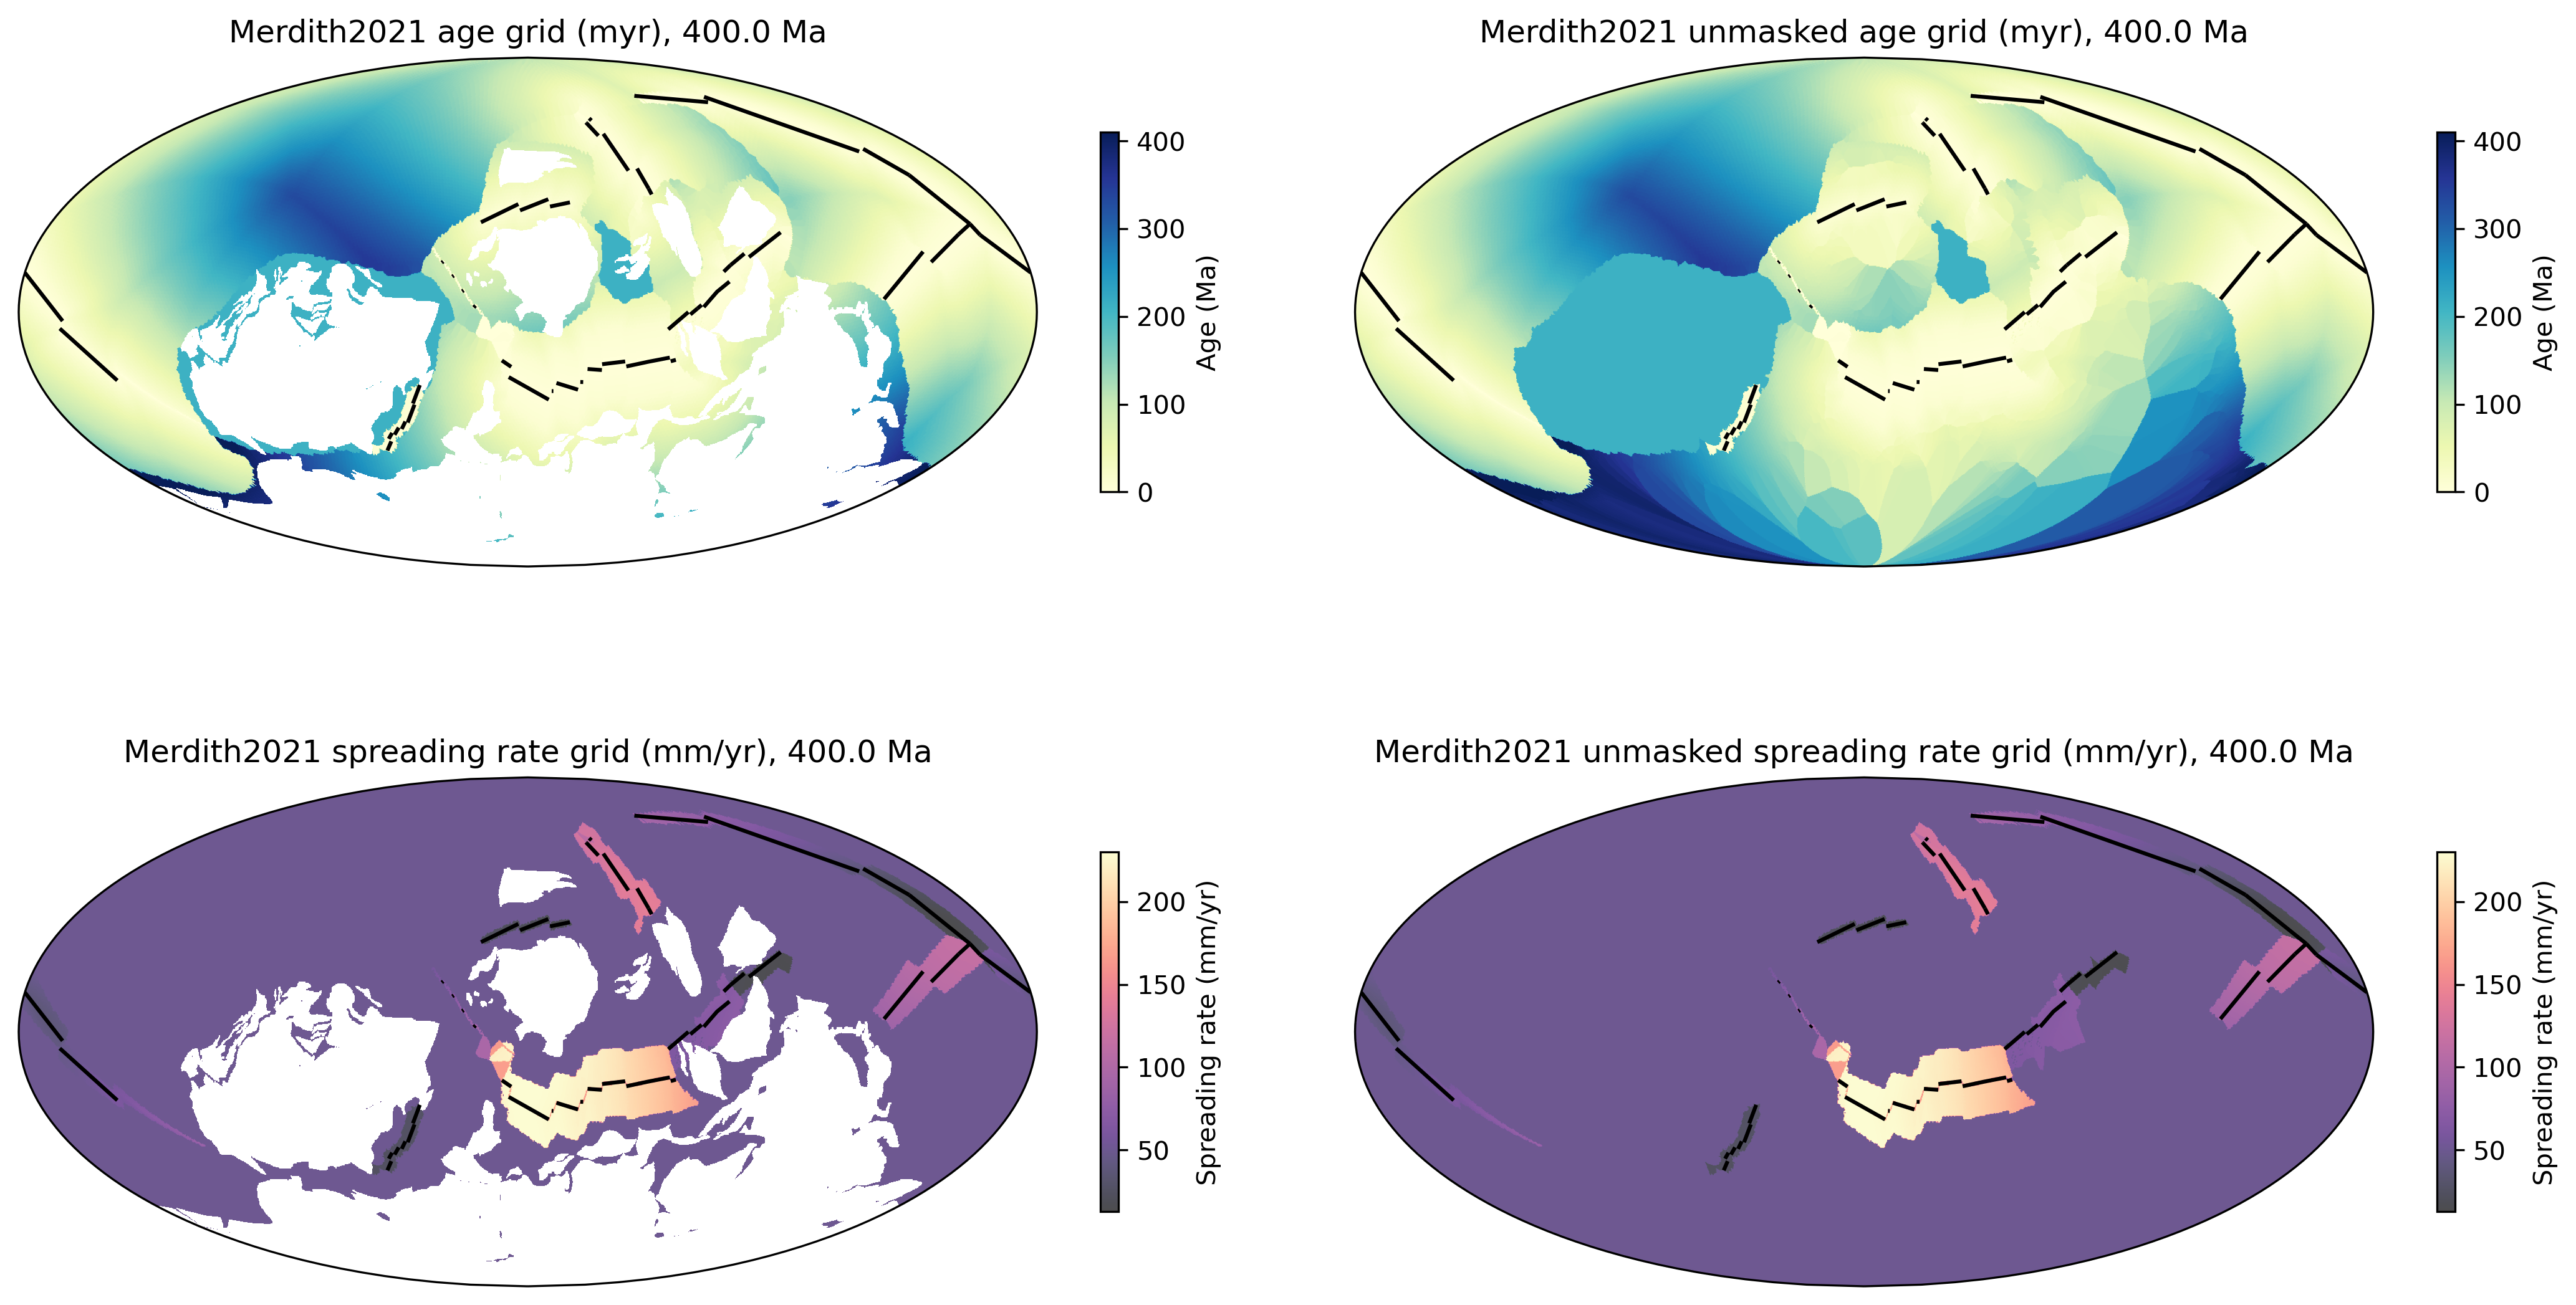

In [16]:
time = min_time

# Process age grids
agegrid_filename = "{}/{}_SEAFLOOR_AGE_grid_{}Ma.nc".format(seafloorgrid.save_directory, seafloorgrid.file_collection, time)
age_grid = gplately.grids.Raster(agegrid_filename)
agegrid_unmasked_filename = "{}/{}_SEAFLOOR_AGE_grid_unmasked_{}Ma.nc".format(seafloorgrid.save_directory, seafloorgrid.file_collection, time)
unmasked_age_grid = gplately.grids.Raster(agegrid_unmasked_filename)

# Process spreading rate grids
srgrid_filename = "{}/{}_SPREADING_RATE_grid_{}Ma.nc".format(seafloorgrid.save_directory, seafloorgrid.file_collection, time)
sr_grid = gplately.grids.Raster(srgrid_filename)
srgrid_unmasked_filename = "{}/{}_SPREADING_RATE_grid_unmasked_{}Ma.nc".format(seafloorgrid.save_directory, seafloorgrid.file_collection, time)
unmasked_sr_grid = gplately.grids.Raster(srgrid_unmasked_filename)


# Prepare plots
fig = plt.figure(figsize=(18,10), dpi=300, linewidth=2)
plt.subplots_adjust(wspace=.05, hspace=0) # spacing between subplots 

# Masked agegrid
ax = fig.add_subplot(221, projection=ccrs.Mollweide(central_longitude=20))
gplot.time = time
plt.title("{} age grid (myr), {} Ma".format(seafloorgrid.file_collection, time))
im = gplot.plot_grid(
    ax, 
    age_grid.data, 
    cmap="YlGnBu",
    vmin = 0, 
    vmax =410,
)
gplot.plot_ridges(ax)
plt.colorbar(im, label="Age (Ma)", shrink=0.5, pad=0.05)

# Unmasked agegrid
ax = fig.add_subplot(222, projection=ccrs.Mollweide(central_longitude=20))
gplot.time = time
plt.title("{} unmasked age grid (myr), {} Ma".format(seafloorgrid.file_collection, time))
im = gplot.plot_grid(
    ax, 
    unmasked_age_grid.data, 
    cmap="YlGnBu",
    vmin = 0, 
    vmax =410,
)
gplot.plot_ridges(ax)
plt.colorbar(im, label="Age (Ma)", shrink=0.5, pad=0.05)


# Masked spreading rate grid
ax1 = fig.add_subplot(223, projection=ccrs.Mollweide(central_longitude=20))
gplot.time = time
plt.title("{} spreading rate grid (mm/yr), {} Ma".format(seafloorgrid.file_collection, time))
im1 = gplot.plot_grid(
    ax1, 
    sr_grid.data, 
    cmap="magma",
    alpha=0.7,
)
gplot.plot_ridges(ax1)
plt.colorbar(im1, label="Spreading rate (mm/yr)", shrink=0.5, pad=0.05)

# Unmasked spreading rate grid
ax1 = fig.add_subplot(224, projection=ccrs.Mollweide(central_longitude=20))
gplot.time = time
plt.title("{} unmasked spreading rate grid (mm/yr), {} Ma".format(seafloorgrid.file_collection, time))
im1 = gplot.plot_grid(
    ax1, 
    unmasked_sr_grid.data, 
    cmap="magma",
    alpha=0.7,
)
gplot.plot_ridges(ax1)
plt.colorbar(im1, label="Spreading rate (mm/yr)", shrink=0.5, pad=0.05)

# Save figure
plt.savefig(
    "{}/{}_{}Myr_plots.png".format(
        output_parent_directory,
        seafloorgrid.file_collection,
        int(time),
    ),
    bbox_inches = 'tight',
)